Los Modelos de Lenguaje de Gran Escala (**LLMs**) han demostrado un enorme potencial en diversas aplicaciones de inteligencia artificial, destacando por su habilidad para generar texto coherente y relevante. Sin embargo, un problema significativo asociado con estos modelos es su tendencia a "alucinar", es decir, generar información falsa o incorrecta, especialmente cuando se enfrentan a tareas específicas para las cuales no fueron adecuadamente entrenados. Esta tendencia reduce su fiabilidad en entornos prácticos y puede resultar en consecuencias adversas, particularmente en áreas críticas como la medicina.

Por ejemplo, el despliegue de un LLM en un entorno clínico para asistir en la clasificación de pacientes y responder preguntas médicas básicas puede ser problemático si el modelo genera respuestas no basadas en evidencia médica. Esto podría ocurrir porque el modelo podría estar intentando responder a consultas cuya naturaleza o contexto no estuvo representado durante su fase de entrenamiento. En tales casos, el LLM se ve obligado a "adivinar" o extrapolar respuestas, a menudo recurriendo a generar el token siguiente más probable basado en las estadísticas de su entrenamiento, lo cual no garantiza una respuesta verídica o segura.

La investigación realizada por McCoy et al. (2023) en su estudio "Embers of Autoregression: Understanding Large Language Models Through the Problem They are Trained to Solve" arroja luz sobre este fenómeno. El estudio sugiere que la raíz del problema de las alucinaciones en los LLMs se debe a su manejo inadecuado de tareas, salidas o entradas que no se incluyeron en su conjunto de datos de entrenamiento. Esta incapacidad para procesar adecuadamente entradas desconocidas o inusuales conduce a la generación de respuestas erróneas, subrayando la necesidad de mejorar los métodos de entrenamiento y la evaluación de los modelos para reducir la incidencia de alucinaciones en aplicaciones prácticas.

**Instalamos las dependencias necesarias para el proyecto**

In [1]:
!pip install transformers datasets
!pip install sentencepiece
!pip install selfcheckgpt
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-1

**Cargamos las librerias necesarias**

In [33]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
import ast
from tqdm import tqdm
from selfcheckgpt.modeling_selfcheck import SelfCheckNLI
import torch
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
from sklearn.model_selection import KFold

Ahora descargamos el conjunto de datos de wiki bio (procedente de la pagina de Hugging Face, es por ello que utilizamos la libreria de datasets)

In [3]:
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating evaluation split:   0%|          | 0/238 [00:00<?, ? examples/s]

Lo convertimos en un DataFrame

In [38]:
df = pd.DataFrame([example for example in dataset["evaluation"]])
df["sent_scores_nli"] = None

In [6]:
df.head()

,gpt3_text,wiki_bio_text,gpt3_sentences,annotation,wiki_bio_test_idx,gpt3_text_samples,sent_scores_nli
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",[John Russell Reynolds (1820–1876) was an Engl...,"[major_inaccurate, major_inaccurate, major_ina...",62464,[John Russell Reynolds (1 November 1829 – 11 ...,None
1,"Matthew Aylmer, 1st Baron Aylmer (1708–1794) w...","Admiral of the Fleet Matthew Aylmer, 1st Baron...","[Matthew Aylmer, 1st Baron Aylmer (1708–1794) ...","[minor_inaccurate, minor_inaccurate, minor_ina...",49661,"[""Matthew Aylmer, 1st Baron Aylmer (c. 1650–17...",None
2,Rick Mahler (born Richard Alan Mahler on April...,"Richard Keith Mahler (August 5, 1953 in Austin...",[Rick Mahler (born Richard Alan Mahler on Apri...,"[minor_inaccurate, minor_inaccurate, accurate,...",20483,"[Rick Mahler (January 8, 1956 – May 25, 2005) ...",None
3,James Blair (1732–1782) was an American lawyer...,"James Blair (September 26, 1786 - April 1, 183...",[James Blair (1732–1782) was an American lawye...,"[minor_inaccurate, major_inaccurate, major_ina...",71174,"[James Blair (April 2, 1755 – March 8, 1842) w...",None
4,"Tim Finchem (born August 24, 1947) is an Ameri...","Timothy W. Finchem (born April 19, 1947) is th...","[Tim Finchem (born August 24, 1947) is an Amer...","[minor_inaccurate, accurate, major_inaccurate,...",39945,"[""Tim Finchem (born May 27, 1953) is an Americ...",None


- **gpt3_text**: Esta columna contiene el texto generado por el modelo GPT-3 en respuesta a una indicación que probablemente sea algo así como "Este es un pasaje de Wikipedia sobre {concepto}:". La respuesta intenta emular un extracto de una página de Wikipedia sobre un concepto o persona específica.

- **wiki_bio_text**: Esta es la columna de "verdad de referencia" o "ground truth". Contiene el texto real extraído de una entrada de Wikipedia, que se utiliza para comparar contra la respuesta generada por GPT-3 y evaluar su precisión.

- **gpt3_sentences**: En esta columna, el texto generado de gpt3_text se ha dividido en oraciones. Este desglose facilita el análisis de cada oración individualmente, permitiendo una evaluación detallada de la consistencia y exactitud en comparación con la información de referencia.

- **annotation**: Esta columna alberga las etiquetas o anotaciones que califican la precisión del texto generado por GPT-3. Por ejemplo, podrían incluir etiquetas como "major_inaccurate" para indicar errores significativos en la información proporcionada por el modelo.

- **wiki_bio_test_idx**: Aunque no lo mencionan detalladamente, esta columna parece ser un índice o identificador único para cada entrada del conjunto de datos, posiblemente enlazando a la entrada específica de Wikipedia utilizada para la "ground truth".

- **gpt3_text_samples**: Aquí se encuentran las
N muestras generadas utilizadas para detectar inconsistencias. Estas son diferentes variaciones del texto generado por GPT-3 para la misma indicación, las cuales pueden ser comparadas entre sí y con la respuesta principal para evaluar la consistencia.

# **EDA**


In [8]:
df.shape

(238, 7)

In [9]:
first_row = df.iloc[0]

for col in first_row.index:
    print(f"Contenido de la columna '{col}':")
    print(first_row[col])
    print("-" * 80)

Contenido de la columna 'gpt3_text':
John Russell Reynolds (1820–1876) was an English lawyer, judge, and author. He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge. He was called to the bar in 1845, and became a Queen's Counsel in 1859. He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.

Reynolds was a prolific author, writing on a wide range of topics. He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868). He also wrote on a variety of other topics, including history, biography, and literature. He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorship of Shakespeare (1875). He also wrote a biography of the poet John Keats (1848).
-------------------------------------------------

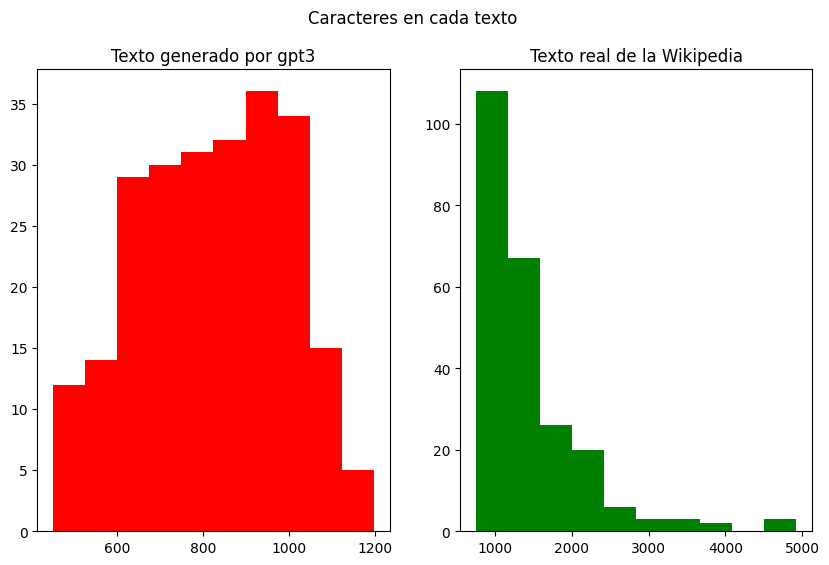

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
text_len=df['gpt3_text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Texto generado por gpt3')
text_len=df['wiki_bio_text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Texto real de la Wikipedia')
fig.suptitle('Caracteres en cada texto')
plt.show()

Observamos distintas distribuciones para cada una de los textos, pero no se pueden sacar conclusiones concluyentes de esto ya que no se puede respaldar con ningún argumento, de momento.

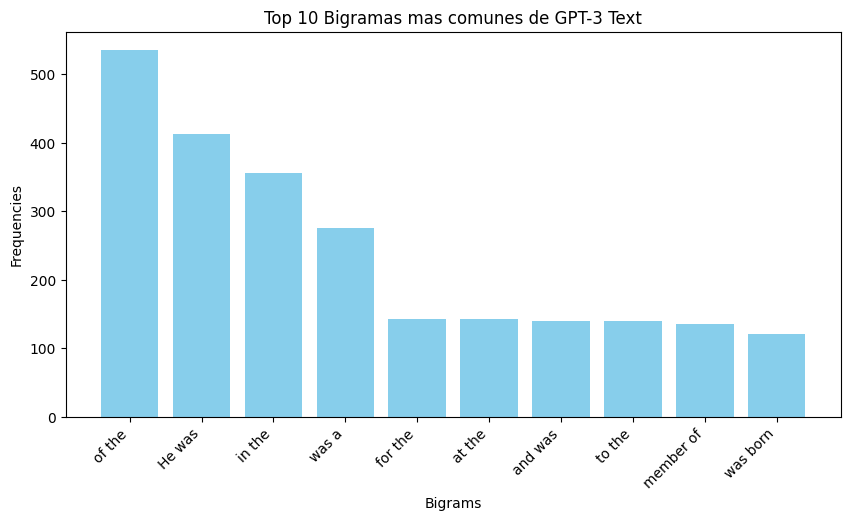

In [32]:
def generate_ngrams(text, n=2):
    return list(ngrams(text.split(), n))

df['gpt3_bigrams'] = df['gpt3_text'].apply(lambda text: generate_ngrams(text, n=2))
bigrams = Counter([bigram for row in df['gpt3_bigrams'] for bigram in row])

# Vamos a graficar los 10 bigramas más comunes
top_bigrams = bigrams.most_common(10)
bigrams_names = [' '.join(x[0]) for x in top_bigrams]
bigrams_values = [x[1] for x in top_bigrams]

plt.figure(figsize=(10, 5))
plt.bar(bigrams_names, bigrams_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Bigrams')
plt.ylabel('Frequencies')
plt.title('Top 10 Bigramas mas comunes de GPT-3 Text')
plt.show()

Graficamos cuales son las palabras mas comunes de nuestra columna de gpt3_text

Dado que el cálculo de las puntuaciones NLI lleva tiempo, podemos manipularlas directamente, accediedno a Google Drive con un dataset con las puntuaciones incluidas:

In [42]:
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH' -O wiki_bio_gpt3_hallucination.csv

--2024-04-17 11:00:50--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2024-04-17 11:00:50--  https://docs.google.com/uc?export=download&id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH
Resolving docs.google.com (docs.google.com)... 142.251.162.101, 142.251.162.138, 142.251.162.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.162.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH&export=download [following]
--2024-04-17 11:00:50--  https://drive.usercontent.google.com/download?id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [43]:
df = pd.read_csv("./wiki_bio_gpt3_hallucination.csv")
df.head()

,gpt3_text,wiki_bio_text,gpt3_sentences,annotation,wiki_bio_test_idx,gpt3_text_samples,sent_scores_nli
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",['John Russell Reynolds (1820–1876) was an Eng...,"['major_inaccurate', 'major_inaccurate', 'majo...",62464,['John Russell Reynolds (1 November 1829 – 11...,"[0.8696355807129293, 0.9287475407123565, 0.931..."
1,"Matthew Aylmer, 1st Baron Aylmer (1708–1794) w...","Admiral of the Fleet Matthew Aylmer, 1st Baron...","['Matthew Aylmer, 1st Baron Aylmer (1708–1794)...","['minor_inaccurate', 'minor_inaccurate', 'mino...",49661,"['""Matthew Aylmer, 1st Baron Aylmer (c. 1650–1...","[0.9112446781247854, 0.9620911836624145, 0.997..."
2,Rick Mahler (born Richard Alan Mahler on April...,"Richard Keith Mahler (August 5, 1953 in Austin...",['Rick Mahler (born Richard Alan Mahler on Apr...,"['minor_inaccurate', 'minor_inaccurate', 'accu...",20483,"['Rick Mahler (January 8, 1956 – May 25, 2005)...","[0.9891034990549088, 0.4388777802581899, 0.955..."
3,James Blair (1732–1782) was an American lawyer...,"James Blair (September 26, 1786 - April 1, 183...",['James Blair (1732–1782) was an American lawy...,"['minor_inaccurate', 'major_inaccurate', 'majo...",71174,"['James Blair (April 2, 1755 – March 8, 1842) ...","[0.9353850647807121, 0.8861920005059801, 0.993..."
4,"Tim Finchem (born August 24, 1947) is an Ameri...","Timothy W. Finchem (born April 19, 1947) is th...","['Tim Finchem (born August 24, 1947) is an Ame...","['minor_inaccurate', 'accurate', 'major_inaccu...",39945,"['""Tim Finchem (born May 27, 1953) is an Ameri...","[0.9961978942155838, 0.2596603611658793, 0.992..."


Por tanto, recordando lo que era cada columna:
- gpt3_text: Texto generado por GPT-3.
-wiki_bio_text: Texto de referencia de una biografía de Wikipedia.
- gpt3_sentences: Segmentos de texto o frases específicas generadas por GPT-3.
annotation: Etiquetas que califican la precisión de la información generada por GPT-3 comparada con la fuente de verdad (en este caso, parece ser la biografía de Wikipedia).
- wiki_bio_test_idx: Un índice o identificador único para el texto de la biografía de Wikipedia.
- gpt3_text_samples: Otras muestras de texto generadas por GPT-3.
- **sent_scores_nli**: Una lista de puntuaciones asignadas por un modelo de NLI que evalúa la exactitud o relevancia de las afirmaciones de gpt3_sentences.

**Evaluación del modelo**

Para ello, usaremos un umbral especifico para llevar a cabo la evaluación

In [44]:
def evaluate_model_with_threshold(data, threshold):
    data['prediction'] = data['probability'].apply(lambda x: 1 if x > threshold else 0)
    precision = precision_score(data['label'], data['prediction'], zero_division=0)
    recall = recall_score(data['label'], data['prediction'], zero_division=0)
    return {'precision': precision, 'recall': recall}

Función para realizar validación cruzada sobre un conjunto de umbrales


In [45]:
def cross_validate_thresholds(data, thresholds, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = {thr: [] for thr in thresholds}

    for train_index, test_index in kf.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        for thr in thresholds:
            metrics = evaluate_model_with_threshold(test_data, thr)
            results[thr].append(metrics)

    return results

Procesando las anotaciones y probabilidades del dataset


In [46]:
df['label'] = df['annotation'].apply(lambda x: 0 if x == "accurate" else 1)
df['probability'] = df['sent_scores_nli'].apply(lambda x: np.mean(ast.literal_eval(x)))

Definimos los umbrales para la evaluación

In [ ]:
thresholds = np.linspace(0, 1, 10)
cv_results = cross_validate_thresholds(df, thresholds)

Imprimos los resultados de la *cross validation*

In [48]:
for thr, metrics in cv_results.items():
    avg_precision = np.mean([m['precision'] for m in metrics])
    avg_recall = np.mean([m['recall'] for m in metrics])
    print(f"Threshold {thr:.2f}: Precision = {avg_precision:.2f}, Recall = {avg_recall:.2f}")

Threshold 0.00: Precision = 1.00, Recall = 1.00
Threshold 0.11: Precision = 1.00, Recall = 1.00
Threshold 0.22: Precision = 1.00, Recall = 0.99
Threshold 0.33: Precision = 1.00, Recall = 0.96
Threshold 0.44: Precision = 1.00, Recall = 0.92
Threshold 0.56: Precision = 1.00, Recall = 0.83
Threshold 0.67: Precision = 1.00, Recall = 0.71
Threshold 0.78: Precision = 1.00, Recall = 0.50
Threshold 0.89: Precision = 1.00, Recall = 0.26
Threshold 1.00: Precision = 0.00, Recall = 0.00


Graficamos los resultados obtenidos

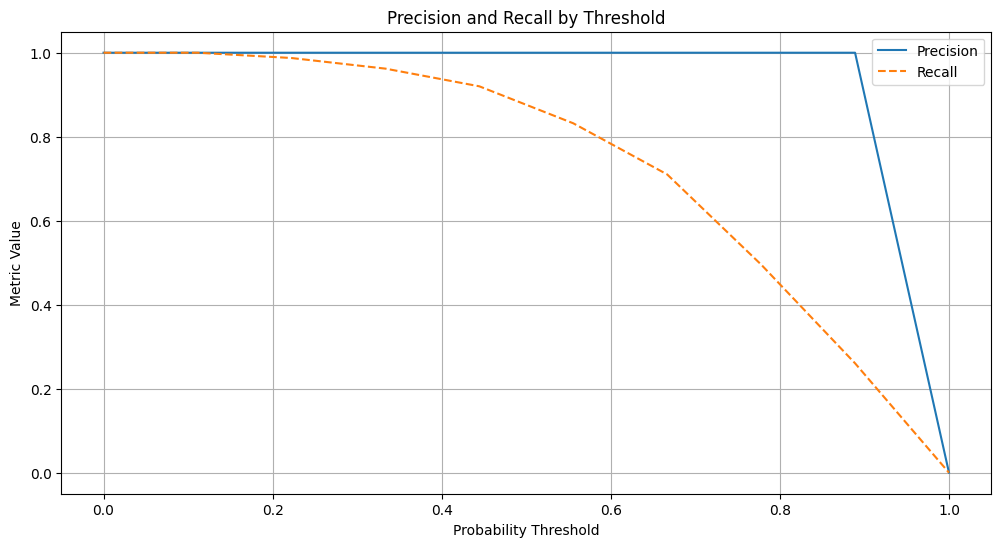

In [50]:
precision_values = [np.mean([m['precision'] for m in metrics]) for _, metrics in cv_results.items()]
recall_values = [np.mean([m['recall'] for m in metrics]) for _, metrics in cv_results.items()]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, recall_values, label='Recall', linestyle='--')
plt.xlabel('Probabilidad de Umbral')
plt.ylabel('Valor de la Metrica')
plt.title('Precision y Recall por Umbrales')
plt.legend()
plt.grid(True)
plt.show()

Ahora que tenemos la puntuación de alucinación con NLI para cada oración, crearemos un DataFrame para facilitar el cálculo de la precisión y el recall para las alucinaciones.

In [8]:
output_df = []

for _, row in df.iterrows():
  scores = row["sent_scores_nli"]
  scores = ast.literal_eval(scores) # We recreate the list of scores per sentence
  sentences = ast.literal_eval(row["gpt3_sentences"])
  annotations = ast.literal_eval(row["annotation"])
  for i, annotation in enumerate(annotations):
    idx = len(output_df)

    output_df.append({
        "index": idx,
        "sentence": sentences[i],
        "wiki_bio_text": row["wiki_bio_text"],
        "annotation": annotation,
        "probability": scores[i]
    })

output_df = pd.DataFrame(output_df)

Usaremos la siguiente convención:

**label**: 1 significa que un humano anotó la oración como una alucinación y es el estándar de referencia, 0 significa verdad.

**probability**: Probabilidad de alucinación, que es simplemente la puntuación NLI anterior.

**prediction**: Etiqueta predicha, 1 si la puntuación es superior a 0.35, de lo contrario, 0.

In [9]:
output_df["label"] = output_df.annotation.apply(lambda x: 0 if x == "accurate" else 1) # We add the ground truth label

In [10]:
threshold = 0.35
output_df["prediction"] = output_df["probability"].apply(lambda x: 1 if x > threshold else 0) # We add the predicted label

In [11]:
output_df

,index,sentence,wiki_bio_text,annotation,probability,label,prediction
0,0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.869636,1,1
1,1,"He was born in London, the son of a barrister,...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.928748,1,1
2,2,"He was called to the bar in 1845, and became a...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.931370,1,1
3,3,He was appointed a judge of the Court of Commo...,"Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.982257,1,1
4,4,"Reynolds was a prolific author, writing on a w...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.221962,1,0
...,...,...,...,...,...,...,...
1903,1903,He was appointed Dean of Clonfert in 1760 and ...,Edward Synge (1659–1741) was an Anglican clerg...,major_inaccurate,0.999400,1,1
1904,1904,"In 1781 he was appointed Archbishop of Tuam, a...",Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.941169,1,1
1905,1905,Synge was a noted scholar and a friend of the ...,Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.755755,1,1
1906,1906,He was a strong supporter of the Church of Ire...,Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.677196,1,1


Vamos a ver la distribucion de la puntuacion de alucinaciones

<Axes: >

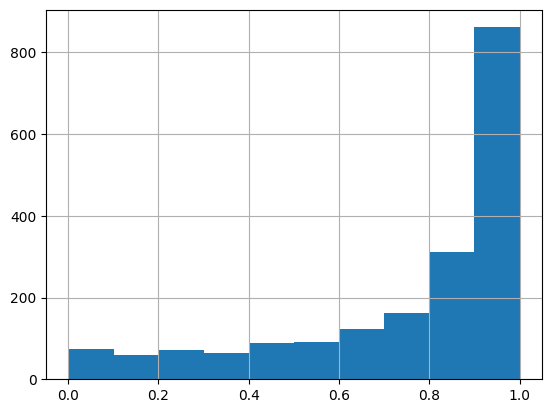

In [12]:
output_df.probability.hist()

Vemos las frases con mas "alucinaciones"

In [13]:
sorted_df = output_df.sort_values(by='probability', ascending=False)
sorted_df

,index,sentence,wiki_bio_text,annotation,probability,label,prediction
1111,1111,Paul Taylor (born Paul Taylor Winger on April ...,"Paul Taylor (born June 4, 1960, San Francisco,...",minor_inaccurate,0.999736,1,1
1867,1867,Gündüz Kılıç (born 28 April 1988) is a Turkish...,Baba Gündüz Kılıç (1918-1980) was a Turkish fo...,minor_inaccurate,0.999716,1,1
1205,1205,Joe Walsh (born 28 April 1988) is an English p...,"For other persons named Joseph/Joe Walsh, see ...",minor_inaccurate,0.999713,1,1
1435,1435,"Stan Heal (born October 28, 1932) is an Americ...","Stan ""Pops"" Heal (30 July 1920 - 15 December 2...",major_inaccurate,0.999712,1,1
1114,1114,"Taylor was born in Cleveland, Ohio, and grew u...","Paul Taylor (born June 4, 1960, San Francisco,...",major_inaccurate,0.999675,1,1
...,...,...,...,...,...,...,...
1215,1215,"He was a major benefactor of the city, donatin...",Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.008564,0,0
440,440,Tommy Nutter (1943–1992) was a British tailor ...,Tommy Nutter (17 April 1943 – 17 August 1992) ...,accurate,0.004858,0,0
905,905,"Lindsay Crouse (born May 12, 1948) is an Ameri...","Lindsay Ann Crouse (born May 12, 1948) is an A...",accurate,0.003348,0,0
1211,1211,Josiah Mason (1795–1881) was an English indust...,Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.001838,0,0


In [14]:
example = sorted_df.iloc[3]
example["sentence"], example["wiki_bio_text"], example["probability"]

('Stan Heal (born October 28, 1932) is an American former professional basketball player.',
 'Stan "Pops" Heal (30 July 1920 - 15 December 2010) was an Australian rules footballer who played for Melbourne in the Victorian Football League (VFL) as well as West Perth in the West Australian National Football League (WANFL) during the 1940s and early 1950s. Heal played his best football as a wingman but was also used on occasions as a rover. The Western Australian spent just one season at Melbourne, who had acquired his services while he was temporarily stationed in Victoria. Despite playing just eight games, he was a member of Melbourne\'s 1941 premiership team. The following week, he played in another premiership, back home in Western Australia with West Perth. He was also a regular interstate representative for Western Australia, winning a Simpson Medal for his performance in a game against South Australia in 1949 and captaining his state at the 1950 Brisbane Carnival. As coach of West 

Ejemplo de una alucinacion donde se hablan de casos completamente independientes, con un alto score de alucinacion.

**Interpretación de resultados**

Ahora veamos las puntuaciones calibradas de recall y precisión. La calibración es clave para construir confianza en un modelo. Idealmente, cuando un modelo proporciona una puntuación de probabilidad de 0.8 de que una muestra dada es una alucinación, nos gustaría que esto se confirmara el 80% de las veces.

Dado que el etiquetado de alucinaciones podría ocurrir en contextos desequilibrados, por ejemplo, si pedimos al LLM que realice tareas fáciles versus difíciles, la precisión y el recall son más relevantes.

Es por eso que observaremos la precisión y el recall para diferentes puntuaciones de probabilidad.

El recall de alucinaciones indica el número de alucinaciones que son detectadas por nuestro modelo para un conjunto de datos dado. Si el recall es de 0.8, significa que hemos identificado correctamente el 80% de las alucinaciones.

La precisión de alucinaciones indica qué tan a menudo las alucinaciones predichas son realmente alucinaciones y no falsos positivos. Una precisión de 0.8 significaría que el 80% de las veces que decimos que una oración es una alucinación, realmente lo es.









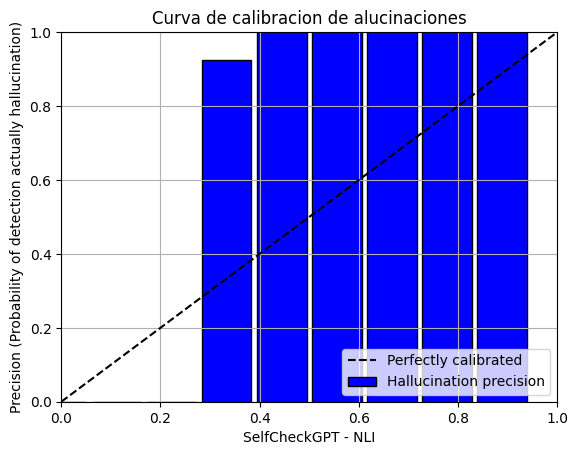

In [15]:
x = []
precisions = []

n_bins = 10
thresholds = np.linspace(0,1,n_bins)
for i in range(len(thresholds)-1):
  min = thresholds[i]
  max = thresholds[i+1]
  bin = output_df.loc[(output_df.probability >= min) & (output_df.probability < max)]
  tp = ((bin.prediction == 1) & (bin.label == 1)).sum()
  fn = ((bin.prediction == 0) & (bin.label == 1)).sum()
  precision = precision_score(bin.prediction.values, bin.label.values)
  x.append(min)
  precisions.append(precision)

plt.bar(x, precisions, width=0.1, color='blue', edgecolor='black', capsize=5, align='center', label='Hallucination precision')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SelfCheckGPT - NLI')
plt.ylabel('Precision (Probability of detection actually hallucination)')
plt.title('Curva de calibracion de alucinaciones')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

Calculamos lo mismo para el recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


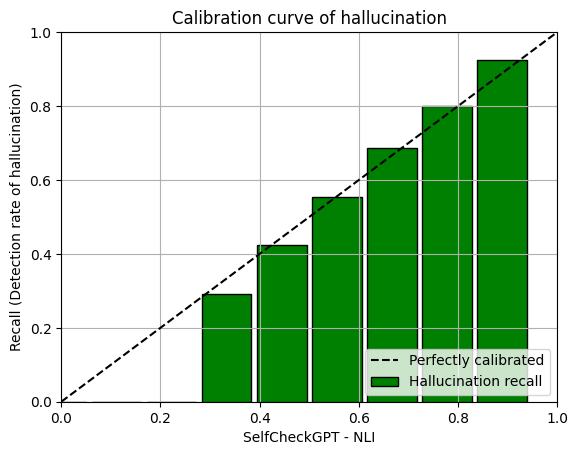

In [16]:
x = []
recalls = []

n_bins = 10
thresholds = np.linspace(0,1,n_bins)
for i in range(len(thresholds)-1):
  min = thresholds[i]
  max = thresholds[i+1]
  bin = output_df.loc[(output_df.probability >= min) & (output_df.probability < max)]
  tp = ((bin.prediction == 1) & (bin.label == 1)).sum()
  fn = ((bin.prediction == 0) & (bin.label == 1)).sum()
  # precision = tp / (tp + fn)
  recall = recall_score(bin.prediction.values, bin.label.values)
  # x.append(f"\[{min}-{max}\]")
  x.append(min)
  recalls.append(recall)

plt.bar(x, recalls, width=0.1, color='green', edgecolor='black', capsize=5, align='center', label='Hallucination recall')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SelfCheckGPT - NLI')
plt.ylabel('Recall (Detection rate of hallucination)')
plt.title('Calibration curve of hallucination')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

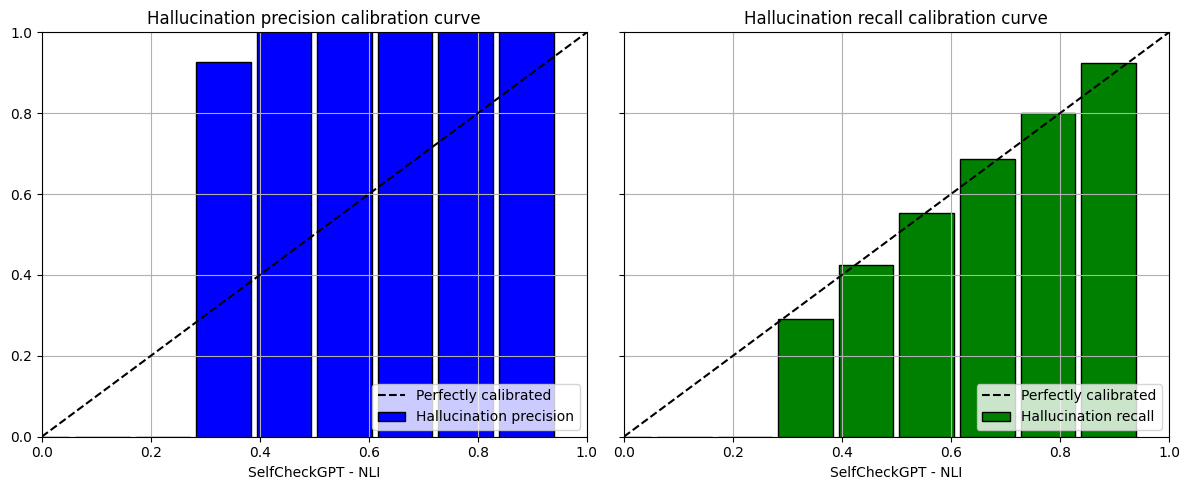

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot the first histogram
axs[0].bar(x, precisions, width=0.1, color='blue', edgecolor='black', capsize=5, align='center', label='Hallucination precision')
axs[0].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('SelfCheckGPT - NLI')
axs[0].set_title('Hallucination precision calibration curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot the second histogram
axs[1].bar(x, recalls, width=0.1, color='green', edgecolor='black', capsize=5, align='center', label='Hallucination recall')
axs[1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])
axs[1].set_xlabel('SelfCheckGPT - NLI')
axs[1].set_title('Hallucination recall calibration curve')
axs[1].legend(loc='lower right')
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

Para poder interpretar correctamente estos graficos, hay que tener clara la diferencia entre la precision y el recall.
- Recall indica qué tan bien el modelo puede identificar todas las alucinaciones reales en un conjunto de datos. Un recall alto significa que el modelo es capaz de detectar una gran proporción de alucinaciones, reflejando su sensibilidad. En este caso, un recall del 80% indica que el modelo identifica correctamente el 80% de las alucinaciones, especialmente a medida que aumenta la puntuación de alucinación predicha (NLI score).
- Precisión mide la exactitud con la que las predicciones del modelo que son etiquetadas como alucinaciones son realmente alucinaciones. Una precisión perfecta, o del 100%, indica que cada vez que el modelo predice una alucinación, esta predicción es correcta, sin falsos positivos. Esto demuestra la especificidad del modelo.

Una vez entendido esto, los resultados obtenidos transmiten lo siguiente:
- El modelo alcanza una precisión perfecta (100%) cuando la puntuación de alucinación es superior a 0.5, indicando que las predicciones de alucinación son extremadamente confiables.
- El recall, correlacionado con la probabilidad de alucinación, mejora a medida que aumenta esta probabilidad. Por ejemplo, con una puntuación NLI de 0.8, el modelo marca correctamente el 80% de las alucinaciones, indicando un alto grado de sensibilidad.
En resumen, el modelo analizado no solo es capaz de detectar alucinaciones con alta precisión, evitando falsos positivos, sino que también demuestra un buen nivel de recall, identificando una gran mayoría de las alucinaciones reales cuando la puntuación de alucinación es alta. Estos resultados sugieren que el modelo es una herramienta confiable y efectiva para verificar la fiabilidad de las respuestas generadas, particularmente en contextos donde la precisión es crucial, como en aplicaciones de IA conversacional.

**Variando el numero de muestras**

En el contexto de la detección de alucinaciones utilizando el modelo SelfCheckGPT, el valor N=20 se refiere al número de respuestas adicionales generadas por el modelo de lenguaje para una única indicación. Es decir, para obtener una puntuación de alucinación para una determinada respuesta, el modelo no solo genera esa respuesta original, sino que también produce 20 variaciones de la misma respuesta. Luego, compara la respuesta original con estas 20 variaciones adicionales para evaluar la coherencia y calcular la probabilidad de que la respuesta original sea una alucinación.

El proceso es intensivo en términos de recursos computacionales y tiempo porque implica generar múltiples respuestas y realizar comparaciones individuales de NLI para cada una de ellas. Exploramos si un número menor de muestras (por ejemplo, N = 3, 10) podría ser suficiente para obtener una evaluación confiable de la alucinación, lo cual sería más práctico y económico.

Para ello descargamos el mismo dataset pero con distintas muestras (samples)

In [18]:
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv' -O wiki_bio_gpt3_hallucination_all_samples.csv

--2024-04-16 10:26:44--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2024-04-16 10:26:44--  https://docs.google.com/uc?export=download&id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv
Resolving docs.google.com (docs.google.com)... 74.125.203.138, 74.125.203.113, 74.125.203.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv&export=download [following]
--2024-04-16 10:26:45--  https://drive.usercontent.google.com/download?id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.187.132, 2404:6800:4008:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.187.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [19]:
df = pd.read_csv("./wiki_bio_gpt3_hallucination_all_samples.csv")

In [20]:
total_samples = 20
n_sample = 3

def get_scores_from_df(df, n_sample=20, total_samples=20, threshold=0.35):

    output_df = []

    for _, example in df.iterrows():
        scores = np.frombuffer(ast.literal_eval(example["sent_scores_nli"]))
        sentences = ast.literal_eval(example["gpt3_sentences"])
        n_sentences = len(sentences)
        scores = scores.reshape(n_sentences, total_samples)
        scores = scores[:,:n_sample]
        scores = scores.mean(axis=-1)

        annotations = ast.literal_eval(example["annotation"])
        for i, annotation in enumerate(annotations):
            idx = len(output_df)

            output_df.append({
                "index": idx,
                "annotation": annotation,
                "probability": scores[i]
            })

    output_df = pd.DataFrame(output_df)
    output_df["label"] = output_df.annotation.apply(lambda x: 0 if x == "accurate" else 1) # We add the ground truth label
    output_df["prediction"] = output_df["probability"].apply(lambda x: 1 if x > threshold else 0) # We add the predicted label
    return output_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricW

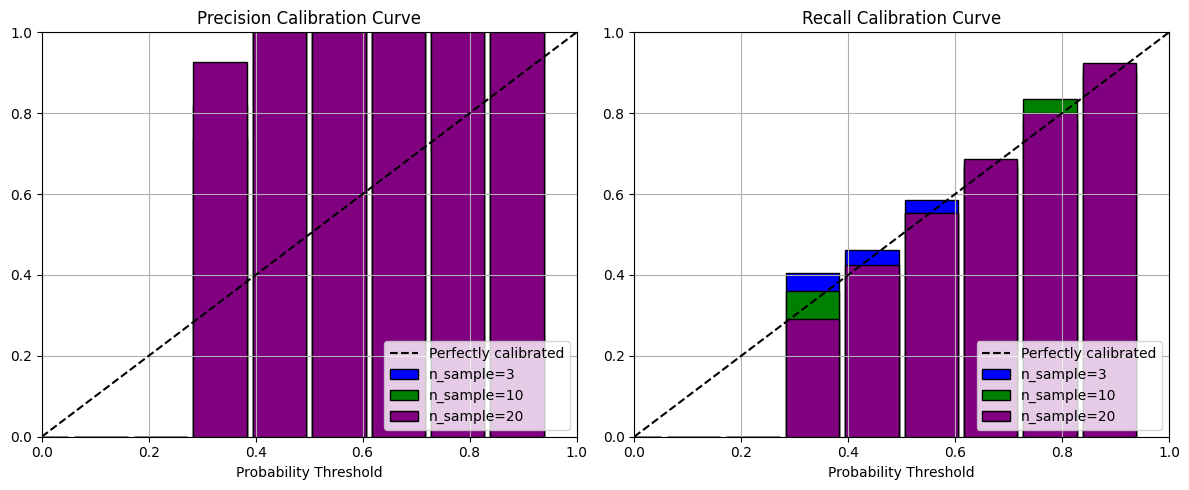

In [21]:
n_samples = [3, 10, 20]
total_samples = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Single row, two columns

n_bins = 10
thresholds = np.linspace(0, 1, n_bins)

colors = ['blue', 'green', 'purple', 'orange']  # Different color for each n_sample

for j, n_sample in enumerate(n_samples):
    output_df = get_scores_from_df(df, n_sample=n_sample, total_samples=total_samples)
    precisions = []
    recalls = []
    x = []

    for i in range(len(thresholds) - 1):
        min_threshold = thresholds[i]
        max_threshold = thresholds[i + 1]
        bin_df = output_df.loc[(output_df.probability >= min_threshold) & (output_df.probability < max_threshold)]
        precision = precision_score(bin_df.prediction.values, bin_df.label.values)
        recall = recall_score(bin_df.prediction.values, bin_df.label.values)
        x.append(min_threshold)
        precisions.append(precision)
        recalls.append(recall)

    # Plot precision and recall for this n_sample
    ax1.bar(x, precisions, width=0.1, color=colors[j], edgecolor='black', label=f'n_sample={n_sample}')
    ax2.bar(x, recalls, width=0.1, color=colors[j], edgecolor='black', label=f'n_sample={n_sample}')

# Set properties for precision plot
ax1.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Precision Calibration Curve')
ax1.legend(loc='lower right')
ax1.grid(True)

# Set properties for recall plot
ax2.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xlabel('Probability Threshold')
ax2.set_title('Recall Calibration Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


Aunque podemos observar ligeras diferencias, el comportamiento general es el mismo, incluso para N=3.

Aunque sigue siendo un número alto y multiplica el costo por 4, este trabajo inicial ofrece una primera orientación hacia una forma práctica, genérica y automática de detectar alucinaciones para construir sistemas de Inteligencia Artificial confiables.

**Conclusiones**

Este cuaderno ha demostrado que es posible identificar alucinaciones de forma automática y consistente utilizando una métrica aplicable a diversas tareas de generación de texto.

Este avance representa un paso significativo hacia la creación de Inteligencia Artificial de confianza, un elemento esencial, aunque no el único, para el desarrollo de sistemas de IA fiables en los que podamos depositar nuestra confianza.